# Yield Prediction: Ahneman Buchwald-Hartwig Dataset

**Goal:** Predict reaction yield using ML

**Approach:** Following ORD creator's method:
1. Convert reactions to DataFrame using `messages_to_dataframe()`
2. One-hot encode categorical inputs (aryl halide, amine, ligand, base, additive)
3. Train neural network to predict yield

**Why this IS real ML:** Same substrates + different conditions → different yields

---

In [48]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2, reaction_pb2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import tensorflow as tf
from tensorflow import keras

sns.set_style("whitegrid")
np.random.seed(42)
tf.random.set_seed(42)

## 1. Load Dataset

In [49]:
# Load Ahneman dataset
dataset_path = "ord-data/data/46/ord_dataset-46ff9a32d9e04016b9380b1b1ef949c3.pb.gz"
data = message_helpers.load_message(dataset_path, dataset_pb2.Dataset)

print(f"Dataset: {data.name}")
print(f"Description: {data.description}")
print(f"Reactions: {len(data.reactions)}")

Dataset: Ahneman
Description: C-N cross-coupling reactions from 10.1126/science.aar5169
Reactions: 4312


In [50]:
# Convert to DataFrame using ORD helper
df = message_helpers.messages_to_dataframe(data.reactions, drop_constant_columns=True)

print(f"DataFrame shape: {df.shape}")
print(f"\nColumns ({len(df.columns)}):")
for col in df.columns:
    print(f"  {col}")

DataFrame shape: (4312, 32)

Columns (32):
  inputs["additive"].components[0].identifiers[0].type
  inputs["additive"].components[0].identifiers[0].value
  inputs["additive"].components[0].identifiers[1].type
  inputs["additive"].components[0].identifiers[1].value
  inputs["additive"].components[0].amount.volume.value
  inputs["additive"].components[0].amount.volume.units
  inputs["additive"].components[0].amount.volume_includes_solutes
  inputs["additive"].components[0].reaction_role
  inputs["additive"].components[0].source.vendor
  inputs["base"].components[0].identifiers[0].value
  inputs["base"].components[0].identifiers[1].value
  inputs["aryl halide"].components[0].identifiers[0].value
  inputs["catalyst"].components[0].identifiers[0].value
  inputs["catalyst"].components[0].identifiers[1].value
  outcomes[0].products[0].identifiers[0].value
  outcomes[0].products[0].measurements[0].percentage.value
  provenance.record_modified[0].time.value
  provenance.record_modified[1].time.

In [51]:
# Preview the data
df.head()

,"inputs[""additive""].components[0].identifiers[0].type","inputs[""additive""].components[0].identifiers[0].value","inputs[""additive""].components[0].identifiers[1].type","inputs[""additive""].components[0].identifiers[1].value","inputs[""additive""].components[0].amount.volume.value","inputs[""additive""].components[0].amount.volume.units","inputs[""additive""].components[0].amount.volume_includes_solutes","inputs[""additive""].components[0].reaction_role","inputs[""additive""].components[0].source.vendor","inputs[""base""].components[0].identifiers[0].value",...,"inputs[""additive""].components[1].identifiers[0].type","inputs[""additive""].components[1].identifiers[0].value","inputs[""additive""].components[1].identifiers[1].type","inputs[""additive""].components[1].identifiers[1].value","inputs[""additive""].components[1].amount.volume.value","inputs[""additive""].components[1].amount.volume.units","inputs[""additive""].components[1].amount.volume_includes_solutes","inputs[""additive""].components[1].reaction_role","inputs[""additive""].components[1].preparations[0].type","inputs[""additive""].components[1].source.vendor"
0,NAME,DMSO,SMILES,CS(=O)C,0.2,MICROLITER,True,SOLVENT,Aldrich,P2Et,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NAME,DMSO,SMILES,CS(=O)C,0.2,MICROLITER,True,SOLVENT,Aldrich,P2Et,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NAME,DMSO,SMILES,CS(=O)C,0.2,MICROLITER,True,SOLVENT,Aldrich,P2Et,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NAME,DMSO,SMILES,CS(=O)C,0.2,MICROLITER,True,SOLVENT,Aldrich,P2Et,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NAME,DMSO,SMILES,CS(=O)C,0.2,MICROLITER,True,SOLVENT,Aldrich,P2Et,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Select Modeling Columns

We need to identify:
- Input columns (SMILES for reactants, catalysts, etc.)
- Output column (yield)

In [52]:
# Find columns containing SMILES identifiers and yield
print("Looking for input and output columns...\n")

smiles_cols = [col for col in df.columns if 'identifiers' in col and 'SMILES' in str(df[col].iloc[0])]
yield_cols = [col for col in df.columns if 'percentage' in col.lower() or 'yield' in col.lower()]

print("Potential SMILES columns:")
for col in smiles_cols[:10]:
    print(f"  {col}")

print(f"\nPotential yield columns:")
for col in yield_cols:
    print(f"  {col}")

Looking for input and output columns...

Potential SMILES columns:
  inputs["additive"].components[0].identifiers[1].type

Potential yield columns:
  outcomes[0].products[0].measurements[0].percentage.value


In [53]:
# Let's explore the input structure more carefully
# Find columns with 'inputs' to understand the reaction components

input_cols = [col for col in df.columns if col.startswith('inputs')]
print(f"Input columns ({len(input_cols)}):")
for col in sorted(set([c.split('.')[0] + '.' + c.split('.')[1] if '.' in c else c.split('[')[0] + '[' + c.split('[')[1].split(']')[0] + ']' for c in input_cols])):
    print(f"  {col}")

Input columns (26):
  inputs["additive"].components[0]
  inputs["additive"].components[1]
  inputs["aryl halide"].components[0]
  inputs["base"].components[0]
  inputs["catalyst"].components[0]


In [54]:
# Explore one reaction to understand structure
rxn = data.reactions[0]

print("=== REACTION INPUTS ===")
for key, inp in rxn.inputs.items():
    print(f"\n{key}:")
    for comp in inp.components:
        role = reaction_pb2.ReactionRole.ReactionRoleType.Name(comp.reaction_role)
        for ident in comp.identifiers:
            ident_type = reaction_pb2.CompoundIdentifier.CompoundIdentifierType.Name(ident.type)
            if ident_type == "SMILES":
                print(f"  {role}: {ident.value[:60]}")

print("\n=== YIELD ===")
for outcome in rxn.outcomes:
    for product in outcome.products:
        for meas in product.measurements:
            if meas.type == reaction_pb2.ProductMeasurement.ProductMeasurementType.YIELD:
                print(f"  Yield: {meas.percentage.value}%")

=== REACTION INPUTS ===

toluidine:
  REACTANT: Cc1ccc(N)cc1
  SOLVENT: CS(=O)C

additive:
  SOLVENT: CS(=O)C

base:
  REAGENT: CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C
  SOLVENT: CS(=O)C

aryl halide:
  REACTANT: FC(F)(F)c1ccc(Cl)cc1
  SOLVENT: CS(=O)C

catalyst:
  CATALYST: CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC2)->[Pd]2(OS(=
  SOLVENT: CS(=O)C

=== YIELD ===
  Yield: 26.888614654541016%


In [ ]:
# Extract data - include ALL input keys, not just non-solvents
def extract_reaction_data(reaction):
    """Extract one SMILES per input key (first non-solvent, or first component if all solvents)."""
    data = {}
    
    for key, inp in reaction.inputs.items():
        clean_key = key.replace(' ', '_').lower()
        
        # First try to get non-solvent component
        found = False
        for comp in inp.components:
            role = reaction_pb2.ReactionRole.ReactionRoleType.Name(comp.reaction_role)
            if role != "SOLVENT":
                for ident in comp.identifiers:
                    if reaction_pb2.CompoundIdentifier.CompoundIdentifierType.Name(ident.type) == "SMILES":
                        data[clean_key] = ident.value
                        found = True
                        break
            if found:
                break
        
        # If no non-solvent found, take the first component anyway (for additive)
        if not found:
            for comp in inp.components:
                for ident in comp.identifiers:
                    if reaction_pb2.CompoundIdentifier.CompoundIdentifierType.Name(ident.type) == "SMILES":
                        data[clean_key] = ident.value
                        found = True
                        break
                if found:
                    break
    
    # Extract yield
    data['yield'] = None
    for outcome in reaction.outcomes:
        for product in outcome.products:
            for meas in product.measurements:
                if meas.type == reaction_pb2.ProductMeasurement.ProductMeasurementType.YIELD:
                    data['yield'] = meas.percentage.value
                    break
    
    return data

# Extract all reactions
reaction_data = [extract_reaction_data(rxn) for rxn in tqdm(data.reactions)]
df_clean = pd.DataFrame(reaction_data)

print(f"Extracted {len(df_clean)} reactions")
print(f"Columns: {list(df_clean.columns)}")

print("\nUnique values per column:")
for col in df_clean.columns:
    if col != 'yield':
        print(f"  {col}: {df_clean[col].nunique()}")

  0%|          | 0/4312 [00:00<?, ?it/s]

NameError: name 'extract_reaction_data_v3' is not defined

In [ ]:
# Check for missing values
print("Missing values:")
print(df_clean.isnull().sum())

# Drop rows without yield
df_clean = df_clean.dropna(subset=['yield'])
print(f"\nReactions with yield: {len(df_clean)}")

Missing values:
toluidine        0
base             0
aryl_halide      0
catalyst         0
yield            0
additive       180
dtype: int64

Reactions with yield: 4312


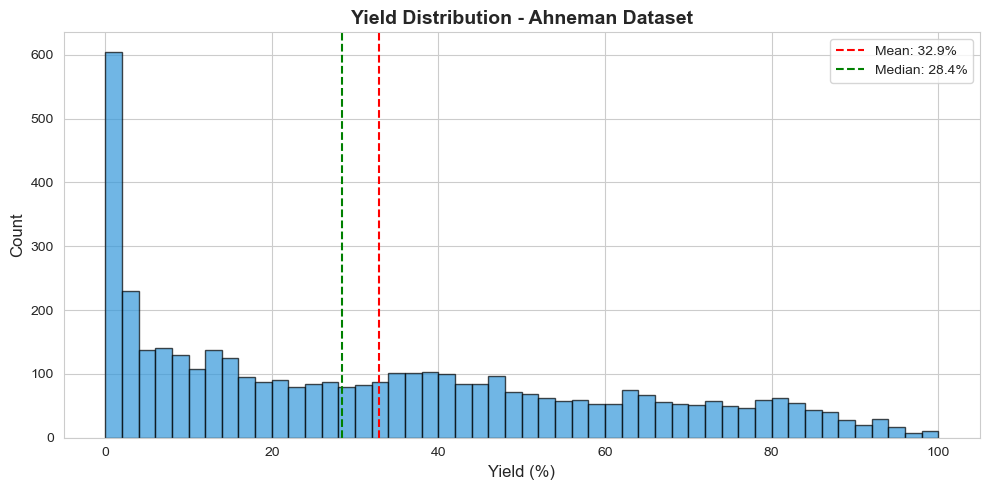

Yield statistics:
  Min:    0.0%
  Max:    100.0%
  Mean:   32.9%
  Median: 28.4%
  Std:    27.5%


In [ ]:
# Yield distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_clean['yield'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax.set_xlabel('Yield (%)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Yield Distribution - Ahneman Dataset', fontsize=14, fontweight='bold')
ax.axvline(x=df_clean['yield'].mean(), color='red', linestyle='--', label=f"Mean: {df_clean['yield'].mean():.1f}%")
ax.axvline(x=df_clean['yield'].median(), color='green', linestyle='--', label=f"Median: {df_clean['yield'].median():.1f}%")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Yield statistics:")
print(f"  Min:    {df_clean['yield'].min():.1f}%")
print(f"  Max:    {df_clean['yield'].max():.1f}%")
print(f"  Mean:   {df_clean['yield'].mean():.1f}%")
print(f"  Median: {df_clean['yield'].median():.1f}%")
print(f"  Std:    {df_clean['yield'].std():.1f}%")

## 3. Feature Engineering: One-Hot Encoding

Convert each unique SMILES to a binary feature (one-hot encoding)

In [ ]:
# Include all 5 input variables
df_model = df_clean.dropna(subset=['yield'])

input_cols = ['catalyst', 'aryl_halide', 'base', 'additive', 'toluidine']
ohe_df = pd.get_dummies(df_model[input_cols], prefix=input_cols)
ohe_df['yield'] = df_model['yield'].values / 100

print(f"One-hot encoded shape: {ohe_df.shape}")
print(f"Features: {ohe_df.shape[1] - 1}")

One-hot encoded shape: (4312, 23)
Features: 22


,catalyst_CC(C)c1cc(C(C)C)c(-c2ccccc2P(C(C)(C)C)(C(C)(C)C)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c(C(C)C)c1,catalyst_CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC2)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c(C(C)C)c1,catalyst_COc1ccc(OC)c(P(C(C)(C)C)(C(C)(C)C)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C,catalyst_COc1ccc(OC)c(P(C23CC4CC(CC(C4)C2)C3)(C23CC4CC(CC(C4)C2)C3)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C,aryl_halide_Brc1ccccn1,aryl_halide_Brc1cccnc1,aryl_halide_CCc1ccc(Br)cc1,aryl_halide_CCc1ccc(Cl)cc1,aryl_halide_CCc1ccc(I)cc1,aryl_halide_COc1ccc(Br)cc1,...,aryl_halide_Clc1cccnc1,aryl_halide_FC(F)(F)c1ccc(Br)cc1,aryl_halide_FC(F)(F)c1ccc(Cl)cc1,aryl_halide_FC(F)(F)c1ccc(I)cc1,aryl_halide_Ic1ccccn1,aryl_halide_Ic1cccnc1,base_CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C,base_CN(C)C(=NC(C)(C)C)N(C)C,base_CN1CCCN2CCCN=C12,yield
0,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,0.268886
1,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,0.240632
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,0.475158
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,0.021268
4,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,0.475864


In [ ]:
# Create one-hot encoding
# Use short prefixes for cleaner feature names
prefix_map = {}
for i, col in enumerate(input_cols):
    # Create short prefix
    prefix_map[col] = col[:10]

ohe_df = pd.get_dummies(df_clean[input_cols], prefix=[prefix_map[c] for c in input_cols])

# Add normalized yield (0-1)
ohe_df['yield'] = df_clean['yield'].values / 100

print(f"One-hot encoded shape: {ohe_df.shape}")
print(f"Features: {ohe_df.shape[1] - 1}")
ohe_df.head()

One-hot encoded shape: (4312, 23)
Features: 22


,catalyst_CC(C)c1cc(C(C)C)c(-c2ccccc2P(C(C)(C)C)(C(C)(C)C)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c(C(C)C)c1,catalyst_CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC2)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c(C(C)C)c1,catalyst_COc1ccc(OC)c(P(C(C)(C)C)(C(C)(C)C)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C,catalyst_COc1ccc(OC)c(P(C23CC4CC(CC(C4)C2)C3)(C23CC4CC(CC(C4)C2)C3)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C,aryl_halid_Brc1ccccn1,aryl_halid_Brc1cccnc1,aryl_halid_CCc1ccc(Br)cc1,aryl_halid_CCc1ccc(Cl)cc1,aryl_halid_CCc1ccc(I)cc1,aryl_halid_COc1ccc(Br)cc1,...,aryl_halid_Clc1cccnc1,aryl_halid_FC(F)(F)c1ccc(Br)cc1,aryl_halid_FC(F)(F)c1ccc(Cl)cc1,aryl_halid_FC(F)(F)c1ccc(I)cc1,aryl_halid_Ic1ccccn1,aryl_halid_Ic1cccnc1,base_CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C,base_CN(C)C(=NC(C)(C)C)N(C)C,base_CN1CCCN2CCCN=C12,yield
0,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,0.268886
1,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,0.240632
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,0.475158
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,0.021268
4,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,0.475864


## 4. Prepare Train/Val/Test Split

In [ ]:
# Create arrays
X = ohe_df.drop(columns=['yield']).values
y = ohe_df['yield'].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Split: 60% train, 10% validation, 30% test
_X_train, X_test, _y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(_X_train, _y_train, test_size=0.1/0.7, random_state=42)

print(f"\nTrain: {X_train.shape[0]}")
print(f"Val:   {X_val.shape[0]}")
print(f"Test:  {X_test.shape[0]}")

X shape: (4312, 22)
y shape: (4312,)

Train: 2586
Val:   432
Test:  1294


## 5. Train Models

In [ ]:
# First, try sklearn models as baseline
print("Training sklearn models...\n")

sklearn_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
}

sklearn_results = {}

for name, model in sklearn_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Metrics (convert back to percentage)
    rmse = np.sqrt(mean_squared_error(y_test * 100, y_pred * 100))
    mae = mean_absolute_error(y_test * 100, y_pred * 100)
    r2 = r2_score(y_test, y_pred)
    
    sklearn_results[name] = {'model': model, 'rmse': rmse, 'mae': mae, 'r2': r2, 'y_pred': y_pred}
    print(f"  RMSE: {rmse:.2f}%, MAE: {mae:.2f}%, R²: {r2:.4f}\n")

Training sklearn models...

Training Random Forest...


  RMSE: 17.84%, MAE: 13.46%, R²: 0.5700

Training Gradient Boosting...
  RMSE: 17.54%, MAE: 13.02%, R²: 0.5844



In [ ]:
# Neural Network (following ORD creator's approach)
print("Training Neural Network...\n")

# Create TensorFlow datasets
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.astype(np.float32), y_train.astype(np.float32))).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.astype(np.float32), y_val.astype(np.float32))).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.astype(np.float32), y_test.astype(np.float32))).batch(batch_size)

# Build model (same architecture as ORD creators)
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(50, activation='sigmoid'),
    keras.layers.Dense(7, activation='sigmoid'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(0.005),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

model.summary()

Training Neural Network...



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 50)             │         1,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           357 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,515 (5.92 KB)

 Trainable params: 1,515 (5.92 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train with early stopping based on validation loss
epochs = 300

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback, early_stopping],
    verbose=1
)

Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1378 - root_mean_squared_error: 0.3712 - val_loss: 0.0623 - val_root_mean_squared_error: 0.2496
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0757 - root_mean_squared_error: 0.2752 - val_loss: 0.0561 - val_root_mean_squared_error: 0.2368
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0632 - root_mean_squared_error: 0.2514 - val_loss: 0.0485 - val_root_mean_squared_error: 0.2201
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0529 - root_mean_squared_error: 0.2301 - val_loss: 0.0413 - val_root_mean_squared_error: 0.2031
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0491 - root_mean_squared_error: 0.2216 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1922
Epoch 6/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0450 - root_mean_squared_error: 0.2122 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

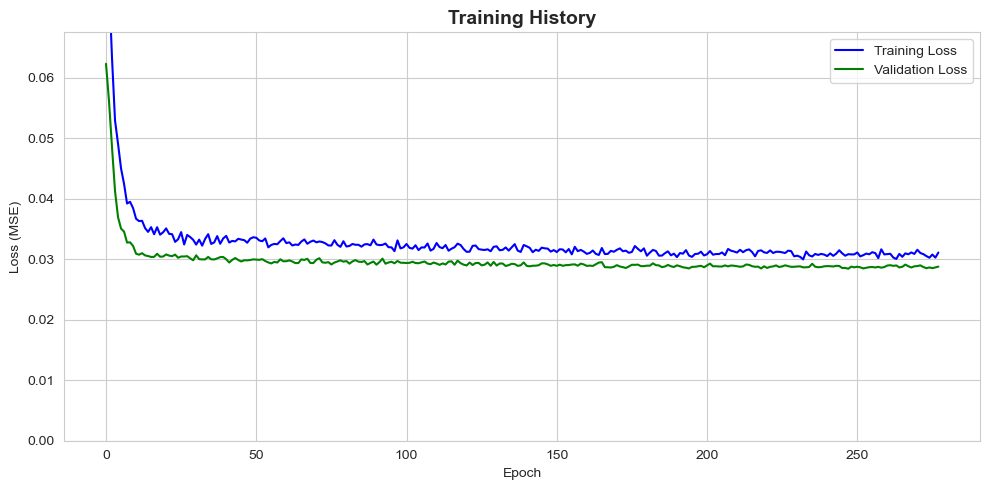

Best epoch: 247


In [ ]:
# Plot training history
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history.history['loss'], label='Training Loss', color='blue')
ax.plot(history.history['val_loss'], label='Validation Loss', color='green')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Training History', fontsize=14, fontweight='bold')
ax.legend()
ax.set_ylim(0, max(history.history['loss'][5:]) * 1.5)  # Zoom in after initial epochs
plt.tight_layout()
plt.show()

best_epoch = np.argmin(history.history['val_loss'])
print(f"Best epoch: {best_epoch}")

In [ ]:
# Evaluate Neural Network on test set
y_pred_nn = model.predict(test_dataset).flatten()

# Metrics
rmse_nn = np.sqrt(mean_squared_error(y_test * 100, y_pred_nn * 100))
mae_nn = mean_absolute_error(y_test * 100, y_pred_nn * 100)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network Test Results:")
print(f"  RMSE: {rmse_nn:.2f}%")
print(f"  MAE:  {mae_nn:.2f}%")
print(f"  R²:   {r2_nn:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Neural Network Test Results:
  RMSE: 17.48%
  MAE:  13.18%
  R²:   0.5873


## 6. Model Comparison

In [ ]:
# Compare all models
print("="*60)
print("MODEL COMPARISON")
print("="*60)

all_results = {
    **sklearn_results,
    'Neural Network': {'rmse': rmse_nn, 'mae': mae_nn, 'r2': r2_nn, 'y_pred': y_pred_nn}
}

comparison_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'RMSE (%)': [all_results[m]['rmse'] for m in all_results],
    'MAE (%)': [all_results[m]['mae'] for m in all_results],
    'R²': [all_results[m]['r2'] for m in all_results]
}).sort_values('RMSE (%)')

print(comparison_df.to_string(index=False))

# Baseline comparison
mean_baseline_rmse = np.sqrt(mean_squared_error(y_test * 100, np.full_like(y_test, y_train.mean()) * 100))
print(f"\nBaseline (predict mean): RMSE = {mean_baseline_rmse:.2f}%")

MODEL COMPARISON
            Model  RMSE (%)   MAE (%)       R²
   Neural Network 17.479571 13.183407 0.587323
Gradient Boosting 17.541441 13.021259 0.584397
    Random Forest 17.843273 13.458345 0.569971

Baseline (predict mean): RMSE = 27.21%


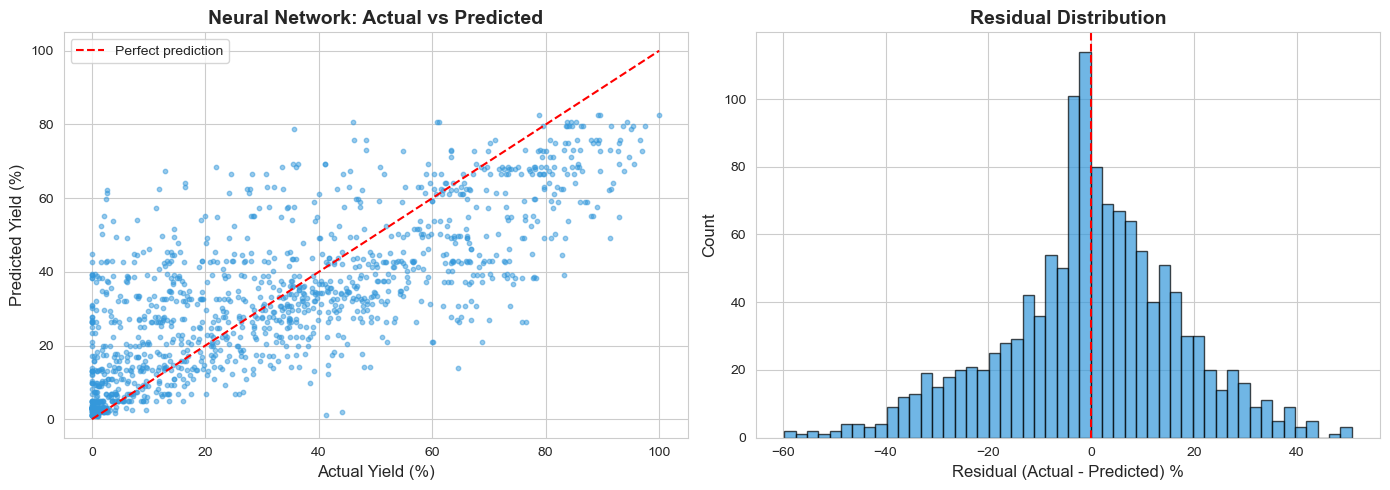


Prediction accuracy (Neural Network):
  Within ±5%:  31.3% of predictions
  Within ±10%: 50.1% of predictions
  Within ±20%: 76.0% of predictions


In [ ]:
# Visualize best model predictions
best_model_name = comparison_df.iloc[0]['Model']
y_pred_best = all_results[best_model_name]['y_pred']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
ax = axes[0]
ax.scatter(y_test * 100, y_pred_best * 100, alpha=0.5, s=10, c='#3498db')
ax.plot([0, 100], [0, 100], 'r--', label='Perfect prediction')
ax.set_xlabel('Actual Yield (%)', fontsize=12)
ax.set_ylabel('Predicted Yield (%)', fontsize=12)
ax.set_title(f'{best_model_name}: Actual vs Predicted', fontsize=14, fontweight='bold')
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)
ax.legend()

# Residual distribution
ax = axes[1]
residuals = (y_test - y_pred_best) * 100
ax.hist(residuals, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax.set_xlabel('Residual (Actual - Predicted) %', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Residual Distribution', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Prediction accuracy
errors = np.abs(y_test - y_pred_best) * 100
print(f"\nPrediction accuracy ({best_model_name}):")
print(f"  Within ±5%:  {100*np.mean(errors <= 5):.1f}% of predictions")
print(f"  Within ±10%: {100*np.mean(errors <= 10):.1f}% of predictions")
print(f"  Within ±20%: {100*np.mean(errors <= 20):.1f}% of predictions")

## 7. Feature Importance (Random Forest)

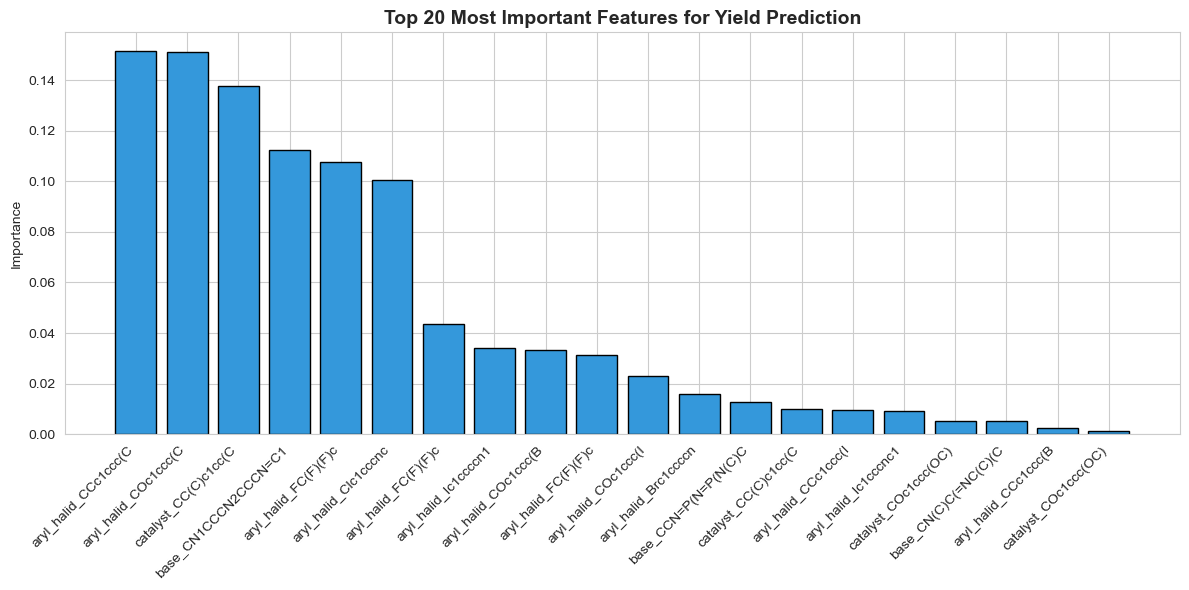

In [ ]:
# Get feature importance from Random Forest
rf = sklearn_results['Random Forest']['model']
feature_names = ohe_df.drop(columns=['yield']).columns
importances = rf.feature_importances_

# Get top 20
indices = np.argsort(importances)[::-1][:20]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(20), importances[indices], color='#3498db', edgecolor='black')
ax.set_xticks(range(20))
ax.set_xticklabels([feature_names[i][:20] for i in indices], rotation=45, ha='right')
ax.set_ylabel('Importance')
ax.set_title('Top 20 Most Important Features for Yield Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Summary

### What we learned:
1. **This IS real ML** - predicting yield from structure/conditions has no simple rules
2. **One-hot encoding works** - treats each unique molecule as a categorical feature
3. **Model comparison** - see which approach works best for this dataset

### Limitations:
- One-hot encoding doesn't generalize to new molecules
- For new substrates, would need molecular fingerprints or other representations

### Next steps:
- Test on external dataset to check generalization
- Try molecular fingerprints instead of one-hot encoding
- Add more condition features (temperature, time, etc.)

In [ ]:
# What components are in the Ahneman dataset?
print("=== EXPLORING AHNEMAN DATA STRUCTURE ===\n")

# Check what input keys exist
input_keys = set()
for rxn in data.reactions[:100]:  # Sample first 100
    for key in rxn.inputs.keys():
        input_keys.add(key)

print("Input keys found:")
for key in sorted(input_keys):
    print(f"  - {key}")

# For each key, what roles and how many unique values?
print("\n=== COMPONENT DETAILS ===")
for rxn in [data.reactions[0]]:
    for key, inp in rxn.inputs.items():
        print(f"\n{key}:")
        for comp in inp.components:
            role = reaction_pb2.ReactionRole.ReactionRoleType.Name(comp.reaction_role)
            for ident in comp.identifiers:
                ident_type = reaction_pb2.CompoundIdentifier.CompoundIdentifierType.Name(ident.type)
                print(f"  Role: {role}, ID type: {ident_type}")
                if ident_type == "SMILES":
                    print(f"  SMILES: {ident.value[:50]}...")

=== EXPLORING AHNEMAN DATA STRUCTURE ===

Input keys found:
  - additive
  - aryl halide
  - base
  - catalyst
  - toluidine

=== COMPONENT DETAILS ===

toluidine:
  Role: REACTANT, ID type: SMILES
  SMILES: Cc1ccc(N)cc1...
  Role: SOLVENT, ID type: NAME
  Role: SOLVENT, ID type: SMILES
  SMILES: CS(=O)C...

additive:
  Role: SOLVENT, ID type: NAME
  Role: SOLVENT, ID type: SMILES
  SMILES: CS(=O)C...

base:
  Role: REAGENT, ID type: NAME
  Role: REAGENT, ID type: SMILES
  SMILES: CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C...
  Role: SOLVENT, ID type: NAME
  Role: SOLVENT, ID type: SMILES
  SMILES: CS(=O)C...

aryl halide:
  Role: REACTANT, ID type: SMILES
  SMILES: FC(F)(F)c1ccc(Cl)cc1...
  Role: SOLVENT, ID type: NAME
  Role: SOLVENT, ID type: SMILES
  SMILES: CS(=O)C...

catalyst:
  Role: CATALYST, ID type: NAME
  Role: CATALYST, ID type: SMILES
  SMILES: CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC2)->...
  Role: SOLVENT, ID type: NAME
  Role: SOLVENT, ID type: SMILES
  SMILES: CS

In [ ]:
# Count unique values for each component
print("=== UNIQUE VALUES PER COMPONENT ===\n")

component_values = {}
for rxn in data.reactions:
    for key, inp in rxn.inputs.items():
        if key not in component_values:
            component_values[key] = set()
        for comp in inp.components:
            for ident in comp.identifiers:
                if reaction_pb2.CompoundIdentifier.CompoundIdentifierType.Name(ident.type) == "SMILES":
                    component_values[key].add(ident.value)

for key, values in sorted(component_values.items()):
    print(f"{key}: {len(values)} unique values")

=== UNIQUE VALUES PER COMPONENT ===

additive: 24 unique values
aryl halide: 16 unique values
base: 4 unique values
catalyst: 5 unique values
toluidine: 2 unique values


In [ ]:
# Better extraction - get the primary component for each input key
def extract_reaction_data(reaction):
    """Extract the main component (not solvent) for each input."""
    data = {}
    
    for key, inp in reaction.inputs.items():
        for comp in inp.components:
            role = reaction_pb2.ReactionRole.ReactionRoleType.Name(comp.reaction_role)
            # Skip solvents - we want the actual reactant/catalyst/reagent
            if role == "SOLVENT":
                continue
            for ident in comp.identifiers:
                if reaction_pb2.CompoundIdentifier.CompoundIdentifierType.Name(ident.type) == "SMILES":
                    clean_key = key.replace(' ', '_').lower()
                    data[clean_key] = ident.value
                    break
            if key.replace(' ', '_').lower() in data:
                break  # Got the main component, move to next input
    
    # Extract yield
    data['yield'] = None
    for outcome in reaction.outcomes:
        for product in outcome.products:
            for meas in product.measurements:
                if meas.type == reaction_pb2.ProductMeasurement.ProductMeasurementType.YIELD:
                    data['yield'] = meas.percentage.value
                    break
    
    return data

# Re-extract all reactions
reaction_data = [extract_reaction_data(rxn) for rxn in tqdm(data.reactions)]
df_clean = pd.DataFrame(reaction_data)

print(f"Extracted {len(df_clean)} reactions")
print(f"Columns: {list(df_clean.columns)}")

# Verify unique values
print("\nUnique values per column:")
for col in df_clean.columns:
    if col != 'yield':
        print(f"  {col}: {df_clean[col].nunique()}")

df_clean.head()

100%|██████████| 4312/4312 [00:00<00:00, 40534.85it/s]

Extracted 4312 reactions
Columns: ['toluidine', 'base', 'aryl_halide', 'catalyst', 'yield', 'additive']

Unique values per column:
  toluidine: 1
  base: 3
  aryl_halide: 15
  catalyst: 4
  additive: 23


,toluidine,base,aryl_halide,catalyst,yield,additive
0,Cc1ccc(N)cc1,CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C,FC(F)(F)c1ccc(Cl)cc1,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC...,26.888615,NaN
1,Cc1ccc(N)cc1,CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C,FC(F)(F)c1ccc(Br)cc1,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC...,24.063225,NaN
2,Cc1ccc(N)cc1,CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C,FC(F)(F)c1ccc(I)cc1,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC...,47.515820,NaN
3,Cc1ccc(N)cc1,CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C,COc1ccc(Cl)cc1,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC...,2.126831,NaN
4,Cc1ccc(N)cc1,CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C,COc1ccc(Br)cc1,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC...,47.586353,NaN


In [ ]:
# Debug: let's see what's in the additive input specifically
rxn = data.reactions[0]

print("=== ADDITIVE STRUCTURE ===")
for key, inp in rxn.inputs.items():
    if key == "additive":
        print(f"\n{key}:")
        for i, comp in enumerate(inp.components):
            role = reaction_pb2.ReactionRole.ReactionRoleType.Name(comp.reaction_role)
            print(f"  Component {i}: Role = {role}")
            for ident in comp.identifiers:
                ident_type = reaction_pb2.CompoundIdentifier.CompoundIdentifierType.Name(ident.type)
                print(f"    {ident_type}: {ident.value[:50] if ident.value else 'None'}...")

=== ADDITIVE STRUCTURE ===

additive:
  Component 0: Role = SOLVENT
    NAME: DMSO...
    SMILES: CS(=O)C...


In [ ]:
# Drop additive column for now, drop rows with missing yield
df_model = df_clean.drop(columns=['additive']).dropna(subset=['yield'])

print(f"Reactions with yield: {len(df_model)}")
print(f"Columns: {list(df_model.columns)}")

# One-hot encode (skip toluidine since it has only 1 value)
input_cols = ['catalyst', 'aryl_halide', 'base']
ohe_df = pd.get_dummies(df_model[input_cols], prefix=input_cols)
ohe_df['yield'] = df_model['yield'].values / 100

print(f"\nOne-hot encoded shape: {ohe_df.shape}")
print(f"Features: {ohe_df.shape[1] - 1}")

Reactions with yield: 4312
Columns: ['toluidine', 'base', 'aryl_halide', 'catalyst', 'yield']

One-hot encoded shape: (4312, 23)
Features: 22
